# Exploratory Data Analysis (EDA) of NYC Metro Database

## Table of Contents:
* [1. Imports](#imports)
* [2. Exploring the dataset](#exploring-dataset)
    * [2.1. Cleaning and transforming data](#cleaning-data)
    * [2.2. Removing outliers](#removing-outliers)
    * [2.3. Vizualizations](#vizualizations)
* [3. Generating datasets for forecasting](#generating-datasets)
    * [3.1. Preprocessing and saving files](#preprocessing-saving)
* [4. Analyzing time series](#analyzing-time-series)
    * [4.1. Check stationarity with Dickey-Fuller test](#check-stationarity)
* [5. Final considerations](#final-considerations)

# 1. Imports <a class="anchor" id="imports"></a>

In [28]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [29]:
# GLOBAL VARIABLES
DATASET_FOLDER = 'dataset'
CSV_FILE = '2015.csv'

# 2. Exploring the dataset <a class="anchor" id="exploring-dataset"></a>

Let's take a look at our data.

In [30]:
df = pd.read_csv(os.path.join(DATASET_FOLDER, CSV_FILE))
df.describe(include=np.object)

,time,ca,unit,scp,station,linename,division,desc
count,10055314,10055314,10055314,10055314,10055314,10055314,10055314,10055314
unique,611470,731,467,219,567,112,6,2
top,2015-09-15 16:00:00,PTH08,R549,00-00-00,34 ST-PENN STA,1,IRT,REGULAR
freq,2398,55280,130452,1008292,223818,1166199,3679948,10016146


In [31]:
df.sample(10)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
6064547,2015-08-09 12:00:00,R210,R044,00-03-05,BROOKLYN BRIDGE,456JZ,IRT,REGULAR,9530150.0,2275695.0
4890160,2015-06-27 16:00:00,N603,R303,00-00-01,21 ST,F,IND,REGULAR,6220995.0,7104916.0
628249,2015-01-23 08:00:00,R413,R325,00-03-00,WHITLOCK AVE,6,IRT,REGULAR,236854.0,97878.0
6335464,2015-08-19 08:00:00,N603,R303,00-00-01,21 ST,F,IND,REGULAR,6298006.0,7187833.0
3455133,2015-05-06 09:00:00,N221,R155,00-00-01,KINGSBRIDGE RD,BD,IND,REGULAR,4462897.0,5268502.0
2995054,2015-04-19 13:00:00,R645,R110,00-00-01,FLATBUSH AVE,25,IRT,REGULAR,6015621.0,5745636.0
3542490,2015-05-09 13:00:00,N553,R422,00-00-01,22 AVE-BAY PKY,F,IND,REGULAR,2013010.0,796072.0
5148815,2015-07-07 03:00:00,R113,R028,01-04-01,FULTON ST,2345ACJZ,IRT,REGULAR,117724176.0,50457408.0
8821118,2015-11-17 04:00:00,R528,R097,00-00-03,JUNCTION BLVD,7,IRT,REGULAR,3481485.0,1231692.0
6340137,2015-08-19 12:00:00,N505,R022,02-00-02,34 ST-HERALD SQ,BDFMNQR,IND,REGULAR,4952523.0,2440000.0


## 2.1. Cleaning and transforming Data <a class="anchor" id="cleaning-data"></a>

First of all it's important to clean our data.

In [32]:
# Check how many null value is on the dataset
df_null_sum = df.isna().sum()
df_null_sum

time        0
ca          0
unit        0
scp         0
station     0
linename    0
division    0
desc        0
entries     0
exits       0
dtype: int64

In [33]:
# Drop rows with null values
df = df.dropna()

# Drop non regular rows
df = df[df.desc == "REGULAR"]

# Combine the columns 'ca', 'unit' and 'scp' into a new one called 'turnstile'
df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']

# Create a separate columns for date and time
df['datetime'] = pd.to_datetime(df.time)

# Drop duplicates
df.drop_duplicates(subset=['station', 'linename', 'turnstile', 'datetime'], keep='first', inplace=True)

# Drop Columns
df.drop(['ca', 'unit', 'scp', 'division', 'time', 'desc'], axis=1, inplace=True)

# Ensure rows are sorted by time
df = df.sort_values(['station', 'turnstile', 'datetime']).reset_index()

The Turnstile entries/exits seems to be a cumulative sum of the occurrences. So, we need to calculate the diff value between turnstile reads.

In [34]:
df_turnstile_group = df.groupby('turnstile')

df['diff_entries'] = df_turnstile_group['entries'].diff().fillna(0)
df['diff_exits'] = df_turnstile_group['exits'].diff().fillna(0)

df.head()

,index,station,linename,entries,exits,turnstile,datetime,diff_entries,diff_exits
0,9900134,1 AV,L,10536080.0,11482385.0,H007-R248-00-00-00,2015-12-26 08:00:00,0.0,0.0
1,9904668,1 AV,L,10536102.0,11482504.0,H007-R248-00-00-00,2015-12-26 12:00:00,22.0,119.0
2,9909222,1 AV,L,10536377.0,11482929.0,H007-R248-00-00-00,2015-12-26 16:00:00,275.0,425.0
3,9913776,1 AV,L,10536886.0,11483458.0,H007-R248-00-00-00,2015-12-26 20:00:00,509.0,529.0
4,9918322,1 AV,L,10537404.0,11484131.0,H007-R248-00-00-00,2015-12-27 00:00:00,518.0,673.0


#### Check diff_entries and diff_exits

As we can see below this columns have a lot of outliers, including negative values and huge values which doesn't make any sense.

       diff_entries    diff_exits
count  1.001615e+07  1.001615e+07
mean   4.156858e+03  3.241724e+03
std    3.784678e+06  3.229032e+06
min   -2.022943e+09 -2.080392e+09
25%    1.100000e+01  9.000000e+00
50%    7.900000e+01  5.400000e+01
75%    2.510000e+02  1.690000e+02
max    2.025053e+09  2.088518e+09


<AxesSubplot:>

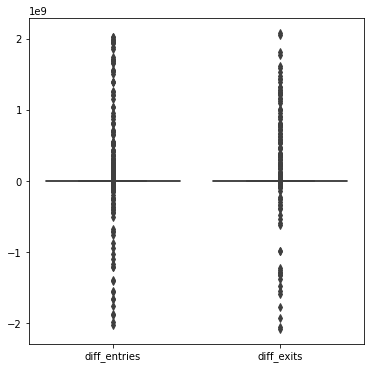

In [35]:
print(df[['diff_entries', 'diff_exits']].describe())

plt.figure(figsize=(6, 6))
sns.boxplot(data=df.loc[:, ['diff_entries', 'diff_exits']])

## 2.2. Removing outliers <a class="anchor" id="removing-outliers"></a>

After removing some outliers our boxplot looks better now.

<AxesSubplot:>

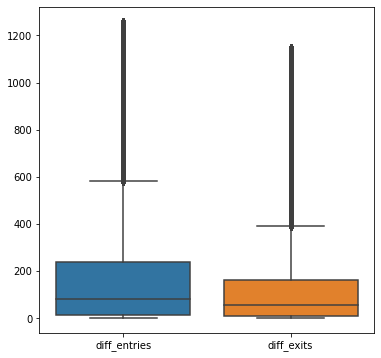

In [36]:
for key in ["diff_entries", "diff_exits"]:
    median_value = df[key].median()
    df[key][df[key] < 0] = median_value
    df[key][df[key] > df[key].quantile(0.99)] = median_value

plt.figure(figsize=(6, 6))
sns.boxplot(data=df.loc[:, ['diff_entries', 'diff_exits']])

## 2.3. Vizualizations <a class="anchor" id="vizualizations"></a>

After cleaning our the data, we can take a look at more generic views considering all the turnstiles.

In [50]:
# Sum entries and exits
df['traffic'] = df['diff_entries'] + df['diff_exits']

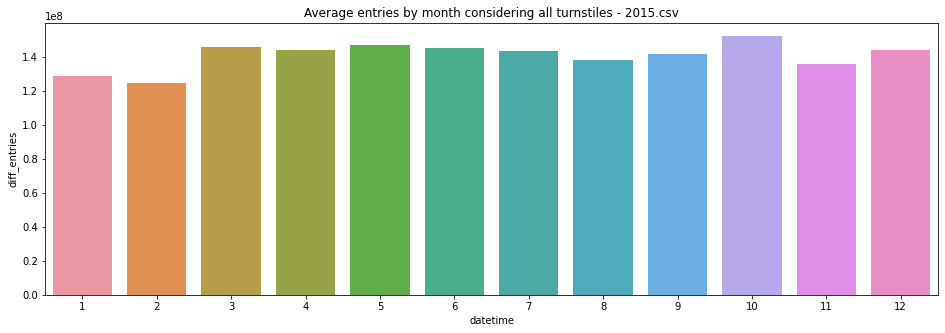

In [51]:
key = 'entries'
df_total_by_month = df.groupby(df.datetime.dt.month)[['diff_' + key]].sum().reset_index()

plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=df_total_by_month,
    x='datetime',
    y='diff_' + key,
)
_ = ax.set(title=f"Average {key} by month considering all turnstiles - {CSV_FILE}")
del df_total_by_month

[Text(0.5, 1.0, 'Number of entries and exits by day - 2015.csv')]

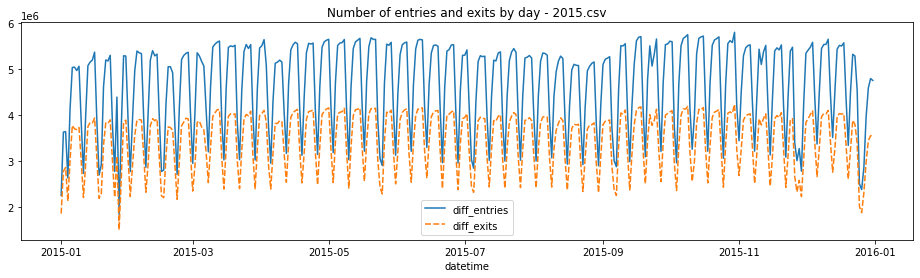

In [13]:
# Plot entries and exits over time
resample_day = df.resample('D', on='datetime')
total_traffic_by_day = resample_day[['diff_entries', 'diff_exits']].sum()

plt.figure(figsize=(16, 4))
sns.lineplot(data=total_traffic_by_day).set(title=f"Number of entries and exits by day - {CSV_FILE}")

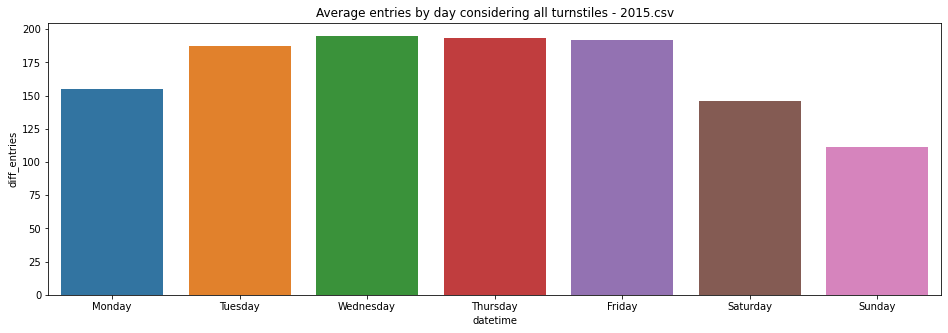

In [14]:
# Plot average entries by day
df_total_by_day = df.groupby(df.datetime.dt.day_of_week)[['diff_entries']].mean().reset_index()

plt.figure(figsize=(16, 5))
ax = sns.barplot(
    data=df_total_by_day,
    x='datetime',
    y='diff_entries',
)
_ = ax.set(title=f"Average entries by day considering all turnstiles - {CSV_FILE}")
_ = ax.set_xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
del df_total_by_day

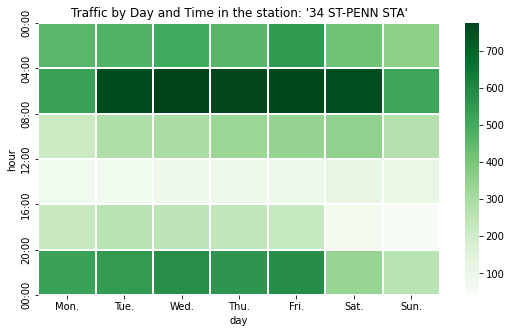

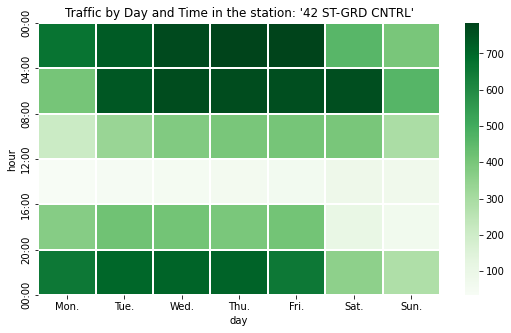

In [15]:
def plot_traffic_by_hour_and_weekday(key, cmap='Greens', n_highest=2):
    
    df_highest_traffic = df.groupby(key)['traffic'].sum().sort_values(ascending=False)

    for elem in df_highest_traffic[:n_highest].keys():
        plt.figure(figsize=(9, 5))
        df_line = df[df[key]==elem]

        # group traffic by day and intervals of 4 hours
        df_traffic = df_line.groupby(
            [df_line.datetime.dt.day_of_week, df_line.datetime.dt.round('4h').dt.hour]
        )['traffic'].mean()

        # rename axis and rotate output
        df_traffic = df_traffic.rename_axis(index=['day','hour']).unstack(level=0).apply(np.roll, shift=1)

        # rename columns
        df_traffic = df_traffic.rename(
            columns={0:'Mon.', 1: 'Tue.', 2: 'Wed.', 3: 'Thu.', 4: 'Fri.', 5: 'Sat.', 6: 'Sun.'}
        )

        # plot
        sns.heatmap(
            df_traffic, cmap=cmap, linewidths=2
        ).set(title="Traffic by Day and Time in the {}: \'{}\'".format(key, elem))
        plt.yticks(range(7),["00:00","04:00","08:00","12:00","16:00","20:00","00:00"])
        plt.show()
        
plot_traffic_by_hour_and_weekday('station', 'Greens')

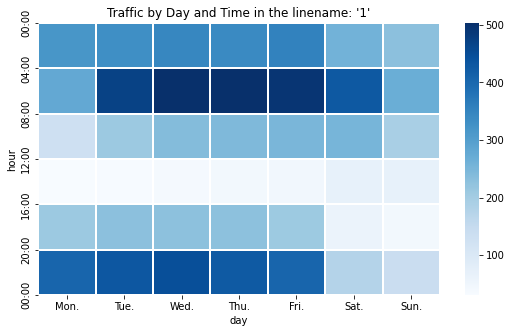

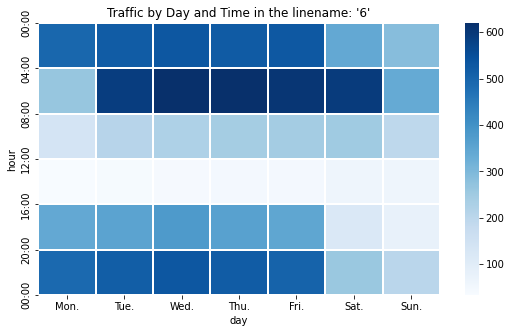

In [16]:
plot_traffic_by_hour_and_weekday('linename', 'Blues')

# 3. Generating datasets for forecasting <a class="anchor" id="generating-datasets"></a>

In [17]:
DATASET_FOLDER = 'dataset'
CSV_FILES = ['20%d.csv' % (year) for year in list(range(10, 18))]

## 3.1. Preprocessing and saving files <a class="anchor" id="preprocessing-saving"></a>

Apply the same preprocessing operations as in the investigation above.

In [18]:
def preprocessing(df):
    # Drop rows with null values
    df = df.dropna()

    # Drop non regular rows
    df = df[df.desc == "REGULAR"]

    # Combine the columns 'ca', 'unit' and 'scp' into a new one called 'turnstile'
    df['turnstile'] = df['ca'] + '-' + df['unit'] + '-' + df['scp']

    # Create a separate columns for date and time
    df['datetime'] = pd.to_datetime(df.time)

    # Drop duplicates
    df.drop_duplicates(subset=['station', 'linename', 'turnstile', 'datetime'], keep='first', inplace=True)

    # Ensure rows are sorted by time
    df = df.sort_values(['station', 'turnstile', 'datetime']).reset_index()
        
    # Calculate diff entries and exits
    df_turnstile_group = df.groupby('turnstile')
    df['diff_entries'] = df_turnstile_group['entries'].diff().fillna(0)
    df['diff_exits'] = df_turnstile_group['exits'].diff().fillna(0)
    
    # Remove outliers
    for key in ["diff_entries", "diff_exits"]:
        median_value = df[key].median()
        df[key][df[key] < 0] = median_value
        df[key][df[key] > df[key].quantile(0.99)] = median_value
    
    # Combine entries and exits into a new variable called traffic
    df['traffic'] = df['diff_entries'] + df['diff_exits']
    
    # Group traffic by station and linename
    df_station = df.groupby(['station', df.datetime.dt.to_period('D')]).traffic.sum().reset_index()
    df_line = df.groupby(['linename', df.datetime.dt.to_period('D')]).traffic.sum().reset_index()
    
    return df_station, df_line

The csv files are relatively large and may not fit in memory, so processing must be done in chunks.

In [19]:
st_filepath = os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.csv')
ln_filepath = os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.csv')

if not os.path.exists(st_filepath) or not os.path.exists(ln_filepath):
    chunksize = 10 ** 6

    df_st = pd.DataFrame()
    df_ln = pd.DataFrame()

    # Processing all CSV FILES. Obs: This operation can take a few minutes.
    for csv_file in CSV_FILES:
        print("Processing:", csv_file)

        for df_chunk in pd.read_csv(os.path.join(DATASET_FOLDER, csv_file), chunksize=chunksize):
            df_st_c, df_ln_c = preprocessing(df_chunk)
            df_st = pd.concat((df_st, df_st_c))
            df_ln = pd.concat((df_ln, df_ln_c))

    # Sort dataframes
    df_st = df_st.sort_values(['station', 'datetime'])[2:-1]
    df_ln = df_ln.sort_values(['linename', 'datetime'])[2:-1]

    # Save them
    df_st.to_csv(st_filepath, index=False)
    df_ln.to_csv(ln_filepath, index=False)

# 4. Analyzing time series <a class="anchor" id="analyzing-time-series"></a>

Loading the datasets

In [20]:
# Dataframe with traffic by station and day
df_st = pd.read_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.csv'), parse_dates=["datetime"])

# Dataframe with traffic by linename and day
df_ln = pd.read_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.csv'), parse_dates=["datetime"])

# Dataframe with the total traffic by day
df_tot = df_ln.groupby('datetime').traffic.sum().reset_index()

In [21]:
df_st.sample(5)

,station,datetime,traffic
310251,86 ST,2012-07-10,140861.0
400749,BEACH 90 ST,2012-10-29,150.0
59399,149/GRAND CONC,2017-04-14,16832.0
838436,NEWARK HW BMEBE,2015-08-23,2543.0
303812,81 ST-MUSEUM,2011-10-27,17276.0


## 4.1. Check stationarity with Dickey-Fuller test <a class="anchor" id="check-stationarity"></a>

In [22]:
def dickey_fuller_test(x, print_results=True):
    result = adfuller(x)
    if print_results:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

    return result

**First let's apply this test to the total traffic.**

In [23]:
dickey_fuller_test(df_tot.traffic);

ADF Statistic: -7.826938
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Considering the Total Traffic our ADF Statistic (-7.798) is lower than the 1% critical value of -3.433.
So it suggests that we can reject the null hypothesis with a significance level of less than 1%.
Which means that our time serie can be considered as stationary and have no time dependent-structure.

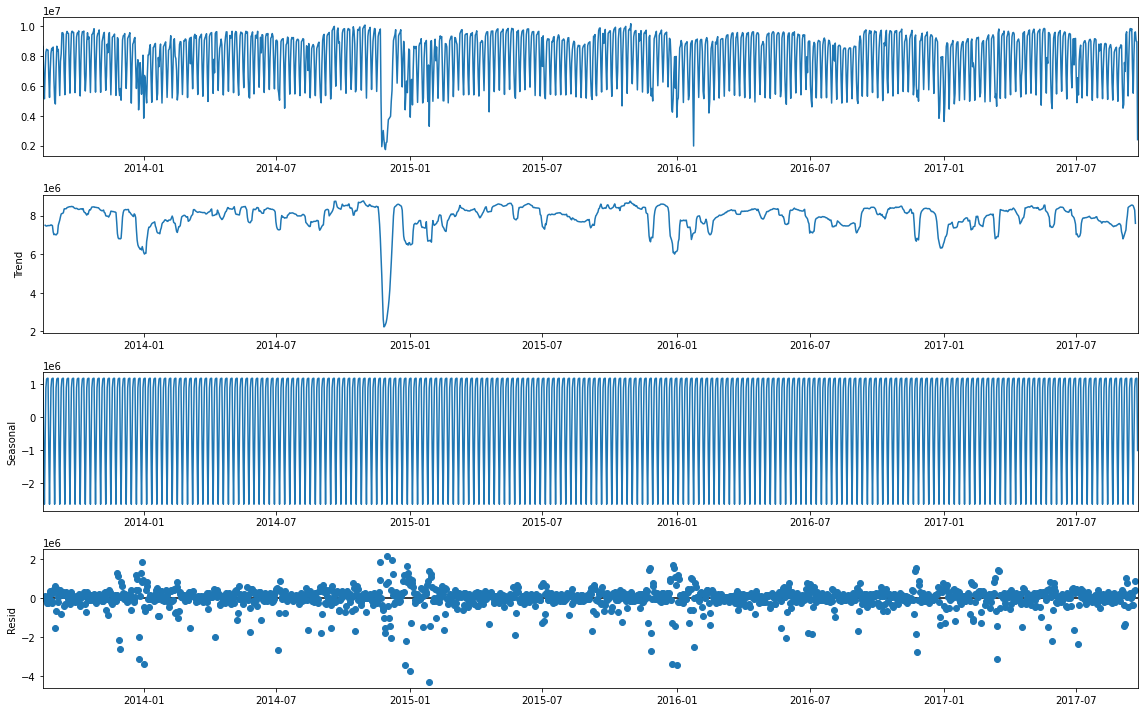

In [24]:
# Decomposing our time series
plt.rc("figure", figsize=(16, 10))
decompose = seasonal_decompose(df_tot[-1500:].set_index('datetime'), period=7, model='additive')
decompose.plot();

The total traffic is a 'well-behaved' time series. The residuals are fairly constant over the time. It means that the additive decomposition do a good job on this data.

**Now let's see the ADF statistic for a set of stations and subway lines.**

In [25]:
h_size = 50

def print_result(df, key, critical_thresh=-2.863):
    print("%18s | ADF Statistic" % (key.capitalize()))
    print("-" * h_size)
    for elem in df[key].unique()[10:20]:
        result = dickey_fuller_test(df[df[key]==elem].traffic, print_results=False)
        mode = 'stationary' if result[0] < critical_thresh else 'non-stationary'
        print('%18s | %.4f, %s' % (elem, result[0], mode))

print("=" * h_size)
print("Dickey-Fuller test | Critical Value: 5% (-2.863)")
print("=" * h_size)
print_result(df_st, 'station')
print("-" * h_size)
print_result(df_ln, 'linename')
print("-" * h_size)

Dickey-Fuller test | Critical Value: 5% (-2.863)
           Station | ADF Statistic
--------------------------------------------------
   116 ST-COLUMBIA | -7.4880, stationary
            121 ST | -1.4219, non-stationary
            125 ST | -7.7148, stationary
            135 ST | -7.3527, stationary
   137 ST CITY COL | -4.5579, stationary
   137 ST-CITY COL | -6.8778, stationary
      138 ST-3 AVE | -7.9185, stationary
    138 ST-GR CONC | -7.5995, stationary
    138/GRAND CONC | -4.9419, stationary
             14 ST | -2.6465, non-stationary
--------------------------------------------------
          Linename | ADF Statistic
--------------------------------------------------
                 2 | -6.9427, stationary
                23 | -6.6399, stationary
              2345 | -7.2855, stationary
          2345ACJZ | -1.6081, non-stationary
         2345BDNQR | -8.0640, stationary
             2345R | -2.9802, stationary
             2345S | -4.7216, stationary
             23ACE 

As we can see the traffic time series of some stations and lines cannot be considered as stationary because of its high ADF Statistic, it indicates that these series are likely to be more difficult to forecast.

Let's take a look at the plot of theses time series.

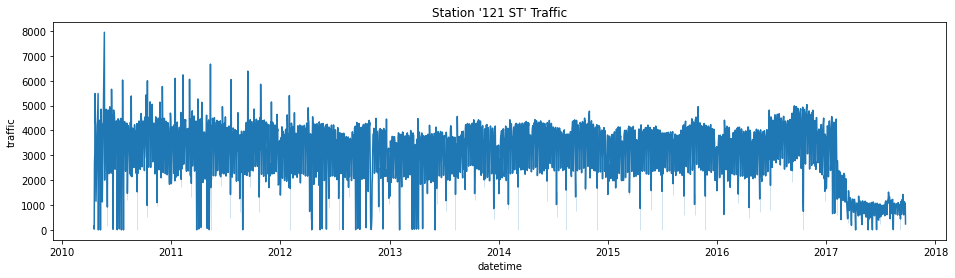

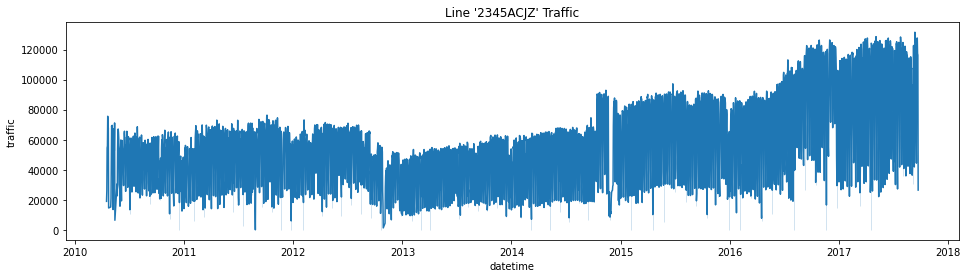

In [54]:
station = '121 ST'
line = '2345ACJZ'

# Plot station traffic
station_traffic = df_st[df_st['station']==station]

plt.figure(figsize=(16, 4))
sns.lineplot(data=station_traffic, x='datetime', y='traffic').set(title="Station \'%s\' Traffic" % (station))
plt.show()

# Plot line traffic
line_traffic = df_ln[df_ln['linename']==line]

plt.figure(figsize=(16, 4))
sns.lineplot(data=line_traffic, x='datetime', y='traffic').set(title="Line \'%s\' Traffic" % (line))
plt.show()

When traffic increases the magnitude of the seasonal component also increases and vice versa. In this case the series is multiplicative.

# 5. Final considerations <a class="anchor" id="final-considerations"></a>

In [54]:
# TO DO